# Aula 12 - OCR Wikipedia / SROIE Continuação
Os objetivos dessa semana são:

* Pré-treino do zero com resolução maior (1024x512) -> (32x16), maior variação de texto e modelo mais simples. Imagem de recibo adicionada como plano de fundo no pré-treino. Esse pré-treino é muito mais complicado.




# Imports

In [ ]:
# Needed if running in remote colab.
# !pip install transformers pytorch-lightning efficientnet-pytorch datasets pyarrow ftfy --upgrade --quiet

In [ ]:
import os
import glob
import json
import time
import random
import traceback
import collections
import subprocess
import textwrap
import shutil
import multiprocessing as mp
from collections import OrderedDict

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import ftfy
import h5py
import torch
import imageio
import numpy as np
import pytorch_lightning as pl
import transformers
import cv2 as cv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import Lambda, ToTensor, Compose, RandomAffine, ToPILImage
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.model import MemoryEfficientSwish

print(f"PL version: {pl.__version__}\npytorch version: {torch.__version__}\nTransformers version: {transformers.__version__}")

PL version: 1.0.7
pytorch version: 1.7.0+cu101
Transformers version: 3.3.1


## Tokenizer
Vai ser o mesmo para todas as operações.

In [ ]:
# This tokenizer will be used by all datasets
TOKENIZER = T5Tokenizer.from_pretrained("t5-small")

MODES = ["TRAIN", "VAL", "TEST"]

# Metrics
Código do Rodrigo.

In [ ]:
def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Dados
Definição das classes Dataset.

* Wikipedia: Dataset para pré-treino como "OCR". 
* SROIE: Dataset para ajuse-fino do modelo pŕe-treinado.



## Download
Download dos dados originais do SROEI e Wikipedia.

In [ ]:
print("Downloading data, please wait...")
if not os.path.isfile("arial.tff"):
    subprocess.run(["gsutil", "-m", "cp", "-n", "gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula7/arial.ttf", "."])
if not os.path.isfile("dataset_sroie_icdar_2019.zip"):
    subprocess.run(["gsutil", "-m", "cp", "-n", "gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip", "."])
    subprocess.run(["unzip", "dataset_sroie_icdar_2019.zip"])
download_wikipedia = load_dataset('wikipedia', '20200501.en')
print("Done.")

Reusing dataset wikipedia (/home/diedre/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/f92599dfccab29832c442b82870fa8f6983e5b4ebbf5e6e2dcbe894e325339cd)


Done.


# Custom Transforms

In [ ]:
class Transform():
    def __call__(self, img, tgt):
        raise NotImplementedError

    def __str__(self):
        raise NotImplementedError


class RandomGaussianNoise(Transform):
    '''
    Randomly adds gaussian or poison noise
    '''
    def __init__(self, noise="gaussian", p=0.2, var=0.0002, mean=0, reset_seed=True):
        super().__init__()
        self.p = p
        self.var = var
        self.mean = mean
        self.sigma = var**0.5
        self.noise = noise
        self.reset_seed = reset_seed
        supported_noises = ["gaussian", "poisson"]
        assert noise in supported_noises, "unsupported noise {} in RandomGaussianNoise, should be {}".format(noise, supported_noises)

    def __call__(self, image):
        if self.reset_seed:
            random.seed()
        if random.random() < self.p:
            if self.noise == "gaussian":
                shape = image.shape
                gauss = np.random.normal(self.mean, self.sigma, shape)
                gauss = gauss.reshape(*shape)
                inoisy = image + gauss
            elif self.noise == "poisson":
                noise_mask = np.random.poisson(image)
                inoisy = image + noise_mask
            return inoisy.astype(np.uint8)
        else:
            return image

    def __str__(self):
        return "RandomGaussianNoise: noise {}, p {}, var {}, mean {}, sigma {}".format(self.noise, self.p, self.var, self.mean, self.sigma)

class Resize(Transform):
    def __init__(self, height, width):
        self.size = (width, height)  # cv2 convention

    def __call__(self, image):
        return cv.resize(image, self.size)

    def __str__(self):
        return f"Resize to ({self.size[1]}, {self.size[0]})."

## Classe Recibos (SROEI)
Abstrai load de recibos pré-processados durante fine-tuning. Estou colocando as quatro informações no target, incluindo data e total.

Tentativa de utilizar uma sample aleatória como "imagem de fundo" no pré-treino.

In [ ]:
class Recibos(Dataset):
    def __init__(self, mode, seq_len=512, transform=Resize(height=1024, width=512)):
        '''
        mode: um de "TRAIN", "VAL", "TEST".
        seq_len: tamanho máximo de sequência. 512 padrão para alinhar com feature 32x16
        transform: transformadas para serem aplicadas somente na imagem.
        '''
        super().__init__()
        assert mode in MODES
        self.mode = mode
        self.seq_len = seq_len

        # Use processed data, in ptrain and ptest folders.
        self.data_folder = "ptest" if self.mode == "TEST" else "ptrain"

        self.images = sorted(glob.glob(f"{self.data_folder}/*.jpg"))
        assert len(self.images) > 0, f"Couldn't find data in {self.data_folder}. Did you download/process data?"

        if self.mode != "TEST":
            train, val = train_test_split(self.images, train_size=0.8, shuffle=True, random_state=4321)
            if self.mode == "TRAIN":
                self.images = train
            elif self.mode == "VAL":
                self.images = val

        self.transform = transform
        print(f"Recibos {self.mode} with transform: {self.transform}.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        '''
        Imagens são cortadas para o menor bounding box. 
        Formato da frase tokenizada segue "company: company, address: address."
        '''
        image_path = self.images[i]
        image_id = os.path.basename(image_path).split('.')[0]
        image = imageio.imread(image_path)

        with open(os.path.join(self.data_folder, f"{image_id}.txt"), 'r') as json_label_file:
            json_label = json.load(json_label_file)
            company = json_label.get("company", "NA")
            date = json_label.get("date", "NA")
            address = json_label.get("address", "NA")
            total = json_label.get("total", "NA")

        original = f"Recibo company: {company}, date: {date}, address: {address} and total: {total}."
        target = TOKENIZER.encode(original,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.seq_len,
                                  return_tensors='pt')[0]
    
        if self.transform is not None:
            image = self.transform(image)

        return image, target, original

    def get_dataloader(self, batch_size, shuffle, num_workers=mp.cpu_count()//2):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [ ]:
debug_recibos = Recibos("TRAIN")

Recibos TRAIN with transform: Resize to (1024, 512)..


255 0


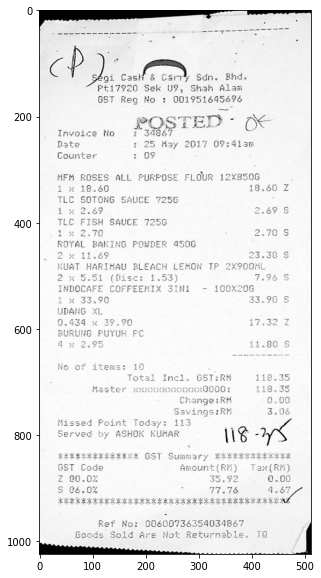

In [ ]:
visualize = 20#@param {type: "integer"}
image, target, original = debug_recibos[visualize]
plt.figure(figsize=(10, 10))
print(image.max(), image.min())
plt.imshow(image)
plt.show()

## Classe wikipedia

Usar imagem maior, para caber mais variações de posição do texto.

A posição, tamanho da fonte e largura do texto varia.

Splits são 0.8/ 0.1 / 0.1.

In [ ]:
class Wikipedia(Dataset):
    '''
    Coloca as 128 primeiras palavras em uma imagem com fundo branco 1024 height e 512 width, com augmentations.
    '''
    def __init__(self, mode, seq_len=512, width=512, height=1024, transform=Compose([RandomGaussianNoise(var=1, p=0.5), ToTensor()])):
        '''
        mode: um de "TRAIN", "VAL", "TEST".
        seq_len: tamanho máximo de sequência. 128 padrão para alinhar com feature 16x8 da efficientnet.
        transform: transformadas para serem aplicadas somente na imagem.
        '''
        super().__init__()
        assert mode in MODES
        self.mode = mode
        self.seq_len = seq_len
        self.width = width
        self.height = height
        self.transform = transform
        self.dataset = load_dataset('wikipedia', '20200501.en')["train"]
        self.recibos = Recibos(mode=mode)
        self.recibos_len = len(self.recibos)

        # 0.8 0.1 0.1 hold-out split
        dataset_range = range(len(self.dataset))

        train_range, test_range = train_test_split(dataset_range, train_size=0.8, random_state=4321, shuffle=True)
        val_range, test_range = train_test_split(test_range, test_size=0.5)

        self.idx_range = {"TRAIN": train_range, "VAL": val_range, "TEST": test_range}

        print(f"Wikipedia {self.mode} with transform: {self.transform}.")

    def __len__(self):
        return len(self.idx_range[self.mode])

    def __getitem__(self, i):
        '''
        Imagens são geradas a partir do caption
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        '''
        try:
            idx = self.idx_range[self.mode][i]

            # Tries to fix possible encoding errors and take only first 128 words from wikipedia texts.
            original = ' '.join(ftfy.fix_text(self.dataset[idx]["text"].encode('ascii', errors='ignore').decode()).split()[:128])

            if self.mode == "TRAIN":
                target = TOKENIZER.encode(original,
                                        padding='max_length',
                                        truncation=True,
                                        max_length=self.seq_len,
                                        return_tensors='pt')[0]
            else:
                # Avoid tokenizing computational cost when not training.
                target = original
            
            background = (self.recibos[random.randint(0, self.recibos_len - 1)][0].astype(np.float32)*0.1).astype(np.uint8) + 200
            image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
            
            if self.transform is not None:
                image = self.transform(image)

            return image, target, original
        except Exception as e:
            print(f"WARNING: Error in dataset: {e}\nSkipping {i}th item from {self.mode} dataset.")
            traceback.print_exc()
            time.sleep(1)
            return self[i + 1]

    def get_dataloader(self, batch_size, shuffle, num_workers=mp.cpu_count()):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

    def text_to_image(self, text: str, max_width: int, max_height: int, background=None):
        '''
        Puts text on image. Notice there are many random parameters for augmentation.
        '''
        # Font size augmentation
        font = ImageFont.truetype("arial.ttf", random.randint(12, 20))  

        # Wrap point augmentation
        text = textwrap.wrap(text, random.randint(30, 50))

        # Empty line augmentation, adds between 0 and 10 empty lines
        nlines = random.randint(0, 10)
        for line in range(nlines):
            position = random.randint(0, len(text) - 1)
            text.insert(position, '')
        text = '\n'.join(text)
        
        # Backgrond color augmentation
        if background is None:
            image = Image.new('RGB', (max_width, max_height), (255, 255, 255))  
        else:
            image = Image.fromarray(background)
        d = ImageDraw.Draw(image)

        # Text position augmentation
        h_point = random.randint(10, 200)
        w_point = random.randint(10, 50)
        d.text((w_point, h_point), text, font=font, fill=(0, 0 , 0)) 

        text_width, text_height = d.textsize(text)

        return np.array(image)


In [ ]:
debug_wikipedia = Wikipedia("TRAIN")

Reusing dataset wikipedia (/home/diedre/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/f92599dfccab29832c442b82870fa8f6983e5b4ebbf5e6e2dcbe894e325339cd)


Recibos TRAIN with transform: Resize to (1024, 512)..
Wikipedia TRAIN with transform: Compose(
    RandomGaussianNoise: noise gaussian, p 0.5, var 1, mean 0, sigma 1.0
    ToTensor()
).


tensor(0.8824) tensor(0.)


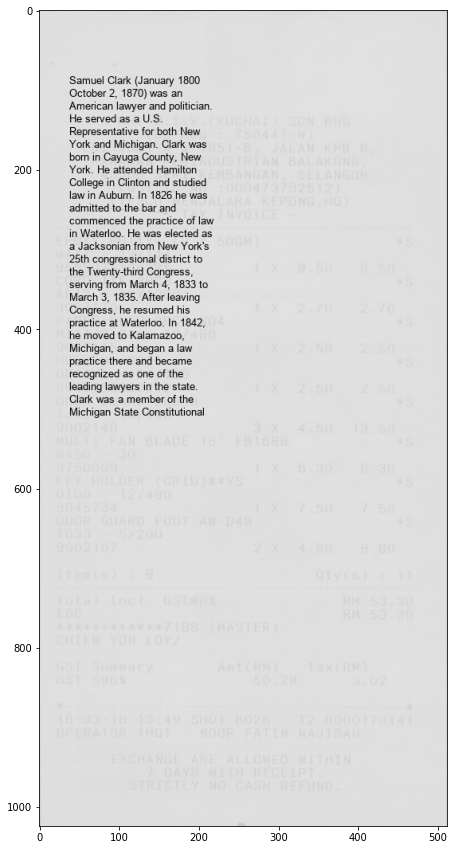

In [ ]:
visualize = 13#@param {type: "integer"}
image, target, original = debug_wikipedia[visualize]
plt.figure(figsize=(15, 15))
print(image.max(), image.min())
plt.imshow(image.numpy().transpose(1, 2, 0))
plt.show()

Reusing dataset wikipedia (/home/diedre/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/f92599dfccab29832c442b82870fa8f6983e5b4ebbf5e6e2dcbe894e325339cd)


Recibos TRAIN with transform: Resize to (1024, 512)..
Wikipedia TRAIN with transform: Compose(
    RandomGaussianNoise: noise gaussian, p 0.5, var 1, mean 0, sigma 1.0
    ToTensor()
).


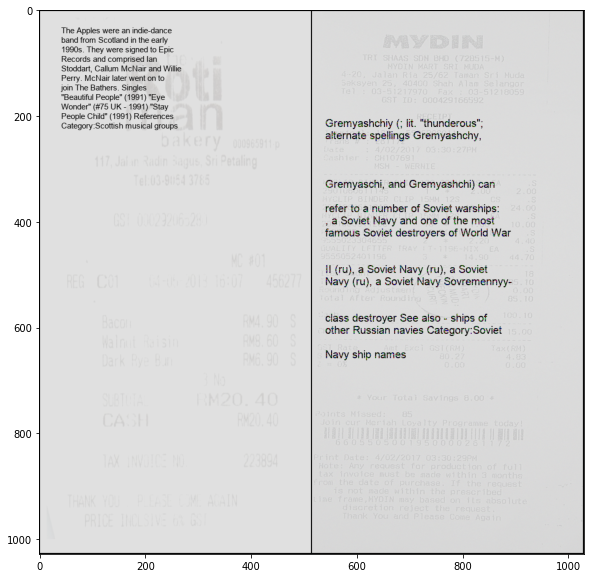

Wikipedia Original: The Apples were an indie-dance band from Scotland in the early 1990s. They were signed to Epic Records and comprised Ian Stoddart, Callum McNair and Willie Perry. McNair later went on to join The Bathers. Singles "Beautiful People" (1991) "Eye Wonder" (#75 UK - 1991) "Stay People Child" (1991) References Category:Scottish musical groups
Wikipedia Tokenized: tensor([   37,  2184,     7,   130,    46,    16,  2498,    18,    26,   663,
         1928,    45,  8288,    16,     8,   778,  5541,     7,     5,   328,
          130,  3814,    12, 24692, 11547,    11,  9418,    26, 15498,  8272,
           26,    26,  1408,     6,  2571,   440, 26842,  2256,    11,  2003,
           23,    15, 18786,     5, 26842,  2256,   865,   877,    30,    12,
         1715,    37, 11247,   277,     5,  7871,     7,    96,   279,  1607,
           17,    99,    83,  2449,   121,  2863,  4729,    61,    96,   427,
           63,    15, 16347,   121,    41,  4663,  3072,  1270,     3,    

In [ ]:
debug_batch = next(iter(DataLoader(Wikipedia("TRAIN"), 
                                   batch_size=2, 
                                   shuffle=True, 
                                   num_workers=mp.cpu_count())))

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(debug_batch[0], 2, normalize=True).numpy().transpose(1, 2, 0))
plt.show()
for caption, original in zip(debug_batch[1], debug_batch[2]):
    print(f"Wikipedia Original: {original}")
    print(f"Wikipedia Tokenized: {caption}")

# CNNT5 v2 OCR
Mesmo CNNT5 da semana passada mas usando o Conv mais eficiente.

In [ ]:
class EfficientConv(nn.Module):
    '''
    Depthwise conv and pointwise conv. 
    Skip connection. 
    '''
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.swish = MemoryEfficientSwish()

        self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)

    def forward(self, x):
        y = self.depthwise(x)
        y = self.project(y)
        y = self.bn(y)
        y = self.swish(y)

        return y + self.skip_connection(x)


class Feature2Embedding(nn.Module):
    '''
    Convert [B, C, H, W] image feature tensor to [B, seq_len, D] (B, 512, 512)
    '''
    def forward(self, x):
        return x.permute(0, 2, 3, 1).reshape(-1, 512, 512)


class CNNT5v2(pl.LightningModule):
    '''
    Custom CNN -> T5 Decoder, with new conv
    Supposes 1024x512 input
    '''
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams

        self.embedding_extractor = nn.Sequential(EfficientConv(3, 16, stride=1),  # [16, 1024, 512]
                                                 EfficientConv(16, 32),  # [32, 512, 256]
                                                 EfficientConv(32, 64),  # [64, 256, 128]
                                                 EfficientConv(64, 128),  # [128, 128, 64]
                                                 EfficientConv(128, 256),  # [256, 64, 32]
                                                 EfficientConv(256, 512),  # [512, 32, 16]
                                                 Feature2Embedding())

        self.decoder = T5ForConditionalGeneration.from_pretrained(self.hparams.t5)

        if not self.hparams.pre_train:
            print(f"Not pre-training, loading trained weight {self.hparams.initial_ckpt}.")
            pre_trained = CNNT5v2.load_from_checkpoint(self.hparams.initial_ckpt)

            self.embedding_extractor.load_state_dict(pre_trained.embedding_extractor.state_dict())
            self.decoder.load_state_dict(pre_trained.decoder.state_dict())

    def forward(self, batch):
        x, labels, original = batch

        embedding = self.embedding_extractor(x)
        
        if self.training:
            return self.decoder(encoder_outputs=(embedding,), labels=labels)[0]       
        else:
            return self.generate(embedding)

    def generate(self, embedding):
        max_length = self.hparams.seq_len

        decoded_ids = torch.full((embedding.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(embedding.device)

        for step in range(max_length):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=(embedding,))[0]
            next_token_logits = logits[:, -1, :]

            # Greedy decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], TOKENIZER.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def training_step(self, batch, batch_idx):
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, on_step=True)
        return loss
        
    def evaluation_step(self, batch):
        '''
        Same step for validation and testing.
        '''
        _, _, originals = batch

        pred_token_phrases = self(batch)
        preds = [TOKENIZER.decode(pred_tokens) for pred_tokens in pred_token_phrases]
        
        exact_matches = []
        f1s = []
        for original, pred in zip(originals, preds):
            exact_matches.append(compute_exact(original, pred))
            f1s.append(compute_f1(original, pred))

        exact_match = np.array(exact_matches).mean()
        f1 = np.array(f1s).mean()

        return exact_match, f1
    
    def validation_step(self, batch, batch_idx):
        exact_match, f1 = self.evaluation_step(batch)

        self.log('val_exact_match', exact_match, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_f1', f1, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        exact_match, f1 = self.evaluation_step(batch)

        self.log('test_exact_match', exact_match, on_epoch=True, on_step=False, prog_bar=True)
        self.log('test_f1', f1, on_epoch=True, on_step=False, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def train_dataloader(self):
        if self.hparams.pre_train:
            print("Using Wikipedia")
            return Wikipedia("TRAIN").get_dataloader(batch_size=self.hparams.bs, shuffle=True)
        else:
            print("Using RECIBOS")
            return Recibos("TRAIN", transform=Compose([Resize(height=1024, width=512), 
                                                       ToTensor()])).get_dataloader(batch_size=self.hparams.bs, shuffle=True)
    
    def val_dataloader(self):
        if self.hparams.pre_train:
            print("Using Wikipedia")
            return Wikipedia("VAL").get_dataloader(batch_size=self.hparams.bs, shuffle=False)
        else:
            print("Using RECIBOS")
            return Recibos("VAL", transform=Compose([Resize(height=1024, width=512), 
                                                     ToTensor()])).get_dataloader(batch_size=self.hparams.bs, shuffle=False)

    def test_dataloader(self):
        if self.hparams.pre_train:
            print("Using Wikipedia")
            return Wikipedia("TEST").get_dataloader(batch_size=self.hparams.bs, shuffle=False)
        else:
            print("Using RECIBOS")
            return Recibos("TEST", transform=Compose([Resize(height=1024, width=512), 
                                                      ToTensor()])).get_dataloader(batch_size=self.hparams.bs, shuffle=False)
            

Após um tempo extremamente longo para finalizar o teste nos 1000 batches (10.000 exemplos), verifica-se o mesmo F1 de 0.96.

# Pre-train do zero denovo CNNT5 v2
imagem maior, fundo complexo, nova arquitetura


In [ ]:
version = "wikipedia_pre_train_big_image" #@param {type: "string"}
initial_ckpt = "" #@param {type: "string"}
lr =  5e-4#@param {type: "number"}
bs =    8#@param {type: "integer"} 
seq_len =  512#@param {type: "integer"}
max_epochs =  2#@param {type: "integer"}
pre_train = True #@param {type: "boolean"}
debug = False #@param {type: "boolean"}
overfit_batches = 0 #@param {type: "integer"}
val_check_interval =  100000#@param {type: "number"}
limit_val_batches =  100#@param {type: "number"}
limit_train_batches = 1.0 #@param {type: "number"}

# Define hyperparameters
hparams = {"version": version,
           "lr": lr,
           "bs": bs,
           "initial_ckpt": initial_ckpt,
           "seq_len": seq_len,
           "max_epochs": max_epochs,
           "debug": debug,
           "t5": "t5-small",
           "pre_train": pre_train,
           "overfit_batches": overfit_batches,
           "val_check_interval": val_check_interval,
           "limit_val_batches": limit_val_batches,
           "limit_train_batches": limit_train_batches}
hparams         

{'bs': 8,
 'debug': False,
 'initial_ckpt': '',
 'limit_train_batches': 1.0,
 'limit_val_batches': 100,
 'lr': 0.0005,
 'max_epochs': 2,
 'overfit_batches': 0,
 'pre_train': True,
 'seq_len': 512,
 't5': 't5-small',
 'val_check_interval': 100000,
 'version': 'wikipedia_pre_train_big_image'}

In [ ]:
model = CNNT5v2(hparams)

if hparams["debug"]:
    checkpoint_callback = None
    logger = None
else:
    checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                       filepath="logs/{epoch}-{val_exact_match:.2f}-{val_f1:.2f}", 
                                                       monitor="val_f1", mode="max")
    logger = pl.loggers.TensorBoardLogger("logs", version=hparams["version"])

# Initialize trainer passing callbacks
trainer = pl.Trainer(gpus=1, 
                     log_gpu_memory=True, 
                     logger=logger, 
                     fast_dev_run=hparams["debug"],
                     val_check_interval=hparams["val_check_interval"],
                     limit_val_batches=hparams["limit_val_batches"],
                     limit_train_batches=hparams["limit_train_batches"],
                     checkpoint_callback=checkpoint_callback,
                     max_epochs=hparams["max_epochs"])


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: DeprecationWarning: Argument `filepath` is deprecated in v1.0 and will be removed in v1.2. Please use `dirpath` and `filename` instead.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: DeprecationWarning: Passing a ModelCheckpoint instance to Trainer(checkpoint_callbacks=...) is deprecated since v1.1 and will no longer be supported in v1.3.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Treino

In [ ]:
torch.cuda.empty_cache()
trainer.fit(model)


  | Name                | Type                       | Params
-------------------------------------------------------------------
0 | embedding_extractor | Sequential                 | 355 K 
1 | decoder             | T5ForConditionalGeneration | 60 M  


Using Wikipedia


Reusing dataset wikipedia (/home/diedre/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/f92599dfccab29832c442b82870fa8f6983e5b4ebbf5e6e2dcbe894e325339cd)


Recibos VAL with transform: Resize to (1024, 512)..
Wikipedia VAL with transform: Compose(
    RandomGaussianNoise: noise gaussian, p 0.5, var 1, mean 0, sigma 1.0
    ToTensor()
).


Using Wikipedia


Reusing dataset wikipedia (/home/diedre/.cache/huggingface/datasets/wikipedia/20200501.en/1.0.0/f92599dfccab29832c442b82870fa8f6983e5b4ebbf5e6e2dcbe894e325339cd)


Recibos TRAIN with transform: Resize to (1024, 512)..
Wikipedia TRAIN with transform: Compose(
    RandomGaussianNoise: noise gaussian, p 0.5, var 1, mean 0, sigma 1.0
    ToTensor()
).


Skipping 4697130th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 800656th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 3497839th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 1237511th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 3615625th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 354333th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 171412th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 4239186th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 2849832th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 3636529th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 3163277th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

Skipping 3462153th item from TRAIN dataset.


Traceback (most recent call last):
  File "<ipython-input-10-e9bf25dc68d0>", line 57, in __getitem__
    image = self.text_to_image(text=original, max_width=self.width, max_height=self.height, background=background)
  File "<ipython-input-10-e9bf25dc68d0>", line 101, in text_to_image
    text_width, text_height = d.textsize(text)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 425, in textsize
    text, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 449, in multiline_textsize
    line, font, spacing, direction, features, language, stroke_width
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageDraw.py", line 430, in textsize
    return font.getsize(text, direction, features, language, stroke_width)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFont.py", line 128, in getsize
    return self.font.getsize(text)
UnicodeEncodeError: 'latin-1' codec can't encode character 

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

## Tensorboard (modelo v1: texto sobre imagem branca)
A curva de pré-treino vermelha se refere ao treino da semana passada, lembrando que o mesmo progrediu até 75% da primeira época (~370000 batches de treino com 10 exemplos), durante **125 horas**, com checks de **10 batches de validação a cada 1000 batches de treino**. 

A **curva azul** representa a continuação do pré-treino por **60 horas**. Note que dessa vez a validação foi feita a cada **em 100 batches de validação a cada 10000 batches de treino**.

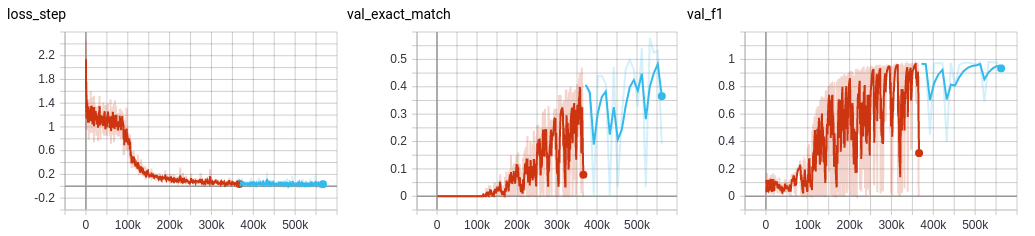

## Tensorboard (modelo v2: texto sobre recibo atenuado, mais dificil)
O modelo que treinou sobre imagens mais complexas não convergiu depois de quase uma semana.


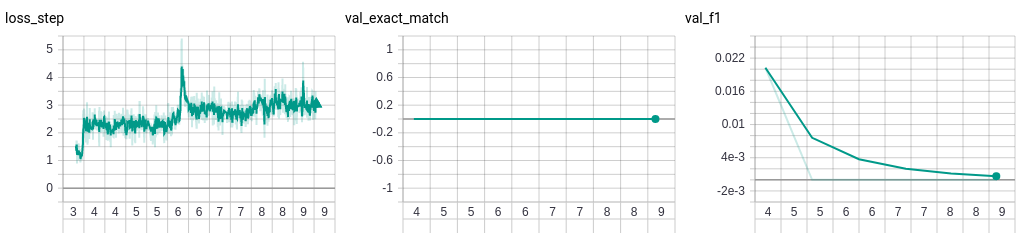

# Conclusion/Future work

* A tentativa de pré-treino com imagens maiores e mais complicadas não funcionou. 

